# Project 2

from Artem Opperman's course: Deep Learning for Predictive Analytics

## 0 Importing tensorflow-gpu==1.14

- Artem's original version of the course used Tensorflow 1.13
- As of 30th September 2019, Tensorflow 2.0 has been released
- The methods and classes used in this notebook are from Tensorflow 1.14

In [1]:
import tensorflow as tf
from IPython.display import clear_output

clear_output()

tf.__version__

'1.14.0'

In [2]:
# check where will the computations of tensorflow be executed

from tensorflow.python.client import device_lib

for device_attribute in device_lib.list_local_devices():
    device_name = device_attribute.name
    device_type = device_attribute.device_type
    print("Active Device: %s (%s)" % (device_name, device_type))

Active Device: /device:CPU:0 (CPU)
Active Device: /device:XLA_CPU:0 (XLA_CPU)
Active Device: /device:GPU:0 (GPU)
Active Device: /device:XLA_GPU:0 (XLA_GPU)


In [3]:
# is tf using the gpu if present in the host machine ?
tf.test.is_gpu_available()

True

In [4]:
# is tf version used here built from source using cuda?
tf.test.is_built_with_cuda()

True

## 1 Problem Statement

The dataset has been collected and analysed during a research collaboration of [Worldline and the Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. If you require more details on current and past projects on related topics from the two organizations, please follow these links: [1](http://mlg.ulb.ac.be/BruFence) and [2](http://mlg.ulb.ac.be/ARTML).


The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have `492` frauds out of `284807` transactions. The dataset is highly unbalanced, the positive class (frauds) account for ~ `0.172%` of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues,the original features and background information about the data are not provided. 

- Features `V1`, `V2`, … `V28` are the principal components obtained with PCA.
- The only features which have not been transformed with PCA are `Time` and `Amount`. 
- Feature `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature `Amount` is the transaction Amount. This feature can be used for example-dependant cost-senstive learning. 
- Feature `Class` is the response variable and it takes value 1 in case of fraud and 0 otherwise.

<br>

(Citation for the project dataset)

_Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015_

<br>

---

___The goal of the project, as set by the instructor is to train an Auto-Encoder on the non-fraudulent transactions, and highlight the difference between them and the fraudulent transactions using the corresponding recreation loss incured by the trained Auto-Encoder___

---

## 2 Decided scope of model evaluation



___If you are working with the dataset, as it is, without any special approaches,___

- Given the extreme class imbalance ratio of `0.172%`, [3](http://rstudio-pubs-static.s3.amazonaws.com/334864_28050f7860dd4927a596872f0cd52401.html) recommends measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC) because a confusion matrix will not be meaningful for classification in this context.
- This [Medium article](https://medium.com/datadriveninvestor/rethinking-the-right-metrics-for-fraud-detection-4edfb629c423) recommends using custom loss functions to train machine learning which incorporates the confusion matrix metrics into the loss curve expression.
- This [stats.stackexchange](https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data) raises the question of choosing the best possible metric for such extremely unbalanced datasets. 


___If you are using a Fully Connected AutoEncoder,___

- the problem becomes an instance of anomaly detection:
    - the model trains on the "normal" occurences and is trained to produce low recreation errors
    - if the model is fed with an "abnormal" occurence, the recreation error is expected to be higher
- In order to highlight the difference in recreation loss between that of fraudulent transactions from the non-fraudulent ones, I will use superimposed PDF curves for them.

## 3 Obtaining the dataset

In [5]:
# In case it needs to be downloaded during notebook execution
# Note: It is 150 MB in size

#import urllib.request

#!rm -rf *.rar
#download_URL = "https://www.filepicker.io/api/file/JinbMqTmTRmysAke03p0"
#urllib.request.urlretrieve(download_URL, "credit_card_fraud.rar")

In [6]:
#!ls

In [7]:
# `patool` can extract WINRAR archives
# you may need to install `unrar` executable for patool.extract_archive to work in this cell
# command for apt: `sudo apt-get install unrar`

#!sudo apt-get install unrar
#!pip install patool

#import patoolib

# in case the archive has already been extracted from a previous iteration
#!rm -rf creditcard_dataset.csv

#patoolib.extract_archive("./credit_card_fraud.rar", outdir = "./")
#clear_output()

In [8]:
#!ls

## 4 EDA

In [9]:
import pandas as pd
import numpy as np

clear_output()

In [10]:
df = pd.read_csv("creditcard_dataset.csv")

In [11]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [12]:
df.sample(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
4974,4536.0,-0.586659,0.779305,1.398090,0.312591,0.579907,0.471269,0.519127,-0.649584,0.088179,...,-0.440872,-0.040786,-0.164658,-0.830509,-0.256202,-0.263743,-0.432948,-0.204091,6.00,0
102901,68418.0,1.080687,-0.137051,1.220083,1.233059,-0.798840,0.472044,-0.789878,0.427304,0.619643,...,0.037804,0.190681,0.040731,-0.028470,0.233471,-0.380534,0.070763,0.021593,4.50,0
64339,51114.0,0.844973,-0.729822,0.407191,1.246153,-0.507633,0.611355,-0.324172,0.121143,0.840142,...,0.159236,0.130504,-0.448460,-0.986475,0.601214,-0.177968,0.022581,0.058913,223.00,0
128543,78747.0,-0.919987,-4.921616,-1.260179,-0.372434,-2.275816,0.197182,0.779444,-0.359003,-2.259303,...,0.614098,-0.483007,-1.150055,0.109418,0.134605,-0.183224,-0.200751,0.209394,1238.12,0
218648,141401.0,2.099534,-1.140007,-0.652243,-0.958399,-1.013315,-0.273365,-1.082023,0.030323,-0.035629,...,0.355668,1.003252,0.044829,-0.463684,-0.140131,-0.079466,-0.001606,-0.058835,39.99,0
99765,67269.0,1.385616,-0.926577,0.727676,-0.813232,-1.088971,0.562682,-1.342658,0.311497,-0.028074,...,0.082805,0.275676,-0.159092,-0.817483,0.455896,-0.139053,0.042604,0.003504,9.95,0
216042,140327.0,-3.808135,-0.930309,-2.083958,-0.935555,0.176735,-1.354239,1.036998,0.515993,-2.515311,...,-0.118159,0.100123,0.116610,0.774070,1.579883,1.102802,-0.646105,-0.398090,106.73,0
272567,165154.0,-0.970104,-0.302945,-0.157199,-1.776012,0.417848,-0.790892,-0.272250,0.086804,-0.819813,...,-0.075377,-0.228602,-0.267207,-1.080517,-0.445073,-0.500569,0.048733,-0.333922,57.39,0
135388,81230.0,-2.570575,3.049185,-1.870932,0.429566,-0.465191,-0.937183,0.026476,0.922860,0.836473,...,-0.116254,0.263499,0.112558,-0.505429,-0.262679,-0.415651,0.068571,-0.324467,0.99,0
270367,164043.0,2.081669,-0.982870,-0.450113,-0.963142,-0.965281,-0.345435,-0.947379,-0.040829,-0.313111,...,0.016347,0.016110,0.297264,-0.333541,-0.461950,-0.491313,0.009757,-0.046074,40.00,0


<br>

_Although the features `V1` to `V28` are obtained from PCA, we could still have a look at their statistical measures here_

In [13]:
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


<br>

- _I do not consider the variable `Time` to be important for prediction, given its meaning in this context_
- _Variable 'Amount' should very important to the response variable_.

In [14]:
df.drop("Time", axis = 1, inplace = True)

<br>

I will be standardizing the variable `Amount` now and this will be reflected across the training, validation and testing dataset. This is not the correct statistical approach, but it makes up by reducing the effort required to demonstrate the project's intentions.

In [15]:
_mean = np.mean(df["Amount"])
_std = np.std(df["Amount"])
df["Amount"] = (df["Amount"] - _mean)/_std

<br>

_I also need to seperate the response variable and the feature dataset for convinience later on_

In [16]:
Y = df["Class"]
df.drop("Class", axis = 1, inplace = True)

X = df.values

<br>

_Now, the label vector`Y` is not required to train the AutoEncoder because it's sole job is to learn to recreate the input data `X`, specifically the ones for non-fraudulent transactions, and create the data's latent representation in a low-dimensional space. So I divided `X` into two subsets, `X_NF` (non-fraudulent) and `X_F` (fraudulent) based on the corresponding value of `Y`. The AutoEncoder will be trained, validated and tested on `X_NF` only._

In [17]:
X_NF = X[Y == 0]
X_F = X[Y != 0]

In [18]:
X_NF.shape, X_F.shape

((284315, 29), (492, 29))

<br>

_We can now perform training-validation-test split, but on `X_NF`_

In [19]:
from sklearn.model_selection import train_test_split

temp = range(len(X_NF))

x_train, x_test, _, temp_test = train_test_split(X_NF,
                                                 temp,
                                                 test_size = 20/100,
                                                 random_state = 1, 
                                                 shuffle = True)

x_val, x_test, _, _ = train_test_split(x_test, 
                                       temp_test, 
                                       test_size = 8/20, 
                                       random_state = 1, 
                                       shuffle = True)
temp_test = None

In [20]:
x_train.shape, x_val.shape, x_test.shape

((227452, 29), (34117, 29), (22746, 29))

<br>

_In order to distinguish the fraudulent transaction from the non-fraudulent one, we need to study the latent representation and define a classification threshold. We can perform the study during the validation and testing phases of the AutoEncoder._

<br>
<br>

## 5 Making the AutoEncoder

### 5.1 Dictionary for Hyperparameters used

In [21]:
hyperparameters = dict(tensorboard_data_dump = "./tensorboard_data_dump/",
                       train_tfrecord_dump_path = "./train_records/",
                       validation_tfrecord_dump_path = "./validation_records/",
                       test_tfrecord_dump_path = "./test_records/",
                       model_dump = "./saved_model_checkpoint/",
                       number_of_features = x_train.shape[1],
                       train_batch_size = 512,
                       validation_batch_size = x_val.shape[0],
                       test_batch_size = x_test.shape[0],
                       num_parallel_calls = 5,
                       train_batch_shuffle_buffer = 512,
                       train_batch_prefetch_buffer = 3,
                       regularization_learning_rate = 1e-5)

### 5.1 The Input Pipeline

#### 5.1.1 Create directories to dump

In [22]:
# if the directories already exist, remove them and their contents
!rm -rf "./train_records/"
!rm -rf "./validation_records/"
!rm -rf "./test_records/"

# recreate the directories
!mkdir -p "./train_records/"
!mkdir -p "./validation_records/"
!mkdir -p "./test_records/"

#### 5.1.2 Function to dump dataset as `tfrecord` files

The function will accept a feature matrix, divide it up by the batch size specified and then write each row of each batch in a `tfrecord` dump file. The arguments of the function are defined as follows:

- `features` = the numpy.ndarray of feature matrix to be dumped (shape = `(m, n)` for `m` observations and `n` features)
- `dump_directory` = path to the local directory where the tfRecord files will be dumped
- `batch_size` = how many rows of dataset and labels will be dumped into each individual `tfrecord` file

<br> 

In [23]:
def dump_dataset_into_tf_records(features, dump_directory, batch_size):
    
    m = features.shape[0]
    i = 0
    j = 0
    writer = None

    for i in range(m):
        
        if i % batch_size == 0:
            if writer is not None:
                writer.close()
            j = j + 1
            record_file_name = dump_directory + "Batch_" + str(j) + ".tfrecord"
            writer = tf.python_io.TFRecordWriter(record_file_name)
        
        feature = features[i, :]

        # to simplify the code, I wrote the dumping code as a seperate function
        dump_into_tfrecord_file(feature, writer)

#### 5.1.3 Function to dump a single `feature` into a `tfrecord` file

The function to dump a single vector `feature` into a `tfrecord` file which is encapsulated into a `tf.python_io.TFRecordWriter` object passed as `writer`. The shapes of `feature` must be `(n,)`.

<br>

___How does the dumping work?___

- Initialize a `tf.python_io.TFRecordWriter` object with an existing directory writer
- Convert `feature` to a list (because `writer` can only dump lists). So, `feature` with shape `(n, )` will become a `list` of length `n`.
- Create a `tf.train.Feature` object out of `feature`. Use the appropiate argument name: `float_list`, `int32_list`, `int64_list` to specify the datatype of the values in the list.
- Create a native python `dict` out of the tf.train.Feature instance of `feature`. This dict will now serve as a write schema of storage for data.
- Since we are creating a pipeline for an AutoEncoder, our input and output data will be the same. We will define our schema accordingly.
- Wrap the dict in a `tf.train.Example` instance. In essence, each row in `feature` is now a single `Example` object to be fed into a Tensorflow Data-Flow Graph.

<br>

___Why do we do this?___

- Need for speed
- Setting a highly-parallelized, optimized and efficient pipeline for flow of data

In [24]:
def dump_into_tfrecord_file(feature,  writer):
    
    feature_as_list = feature.tolist()

    feature_as_Feature_instance = tf.train.Feature(float_list = 
                                                   tf.train.FloatList(value = feature_as_list))
    
    write_schema = {"input":feature_as_Feature_instance, "output":feature_as_Feature_instance}
    write_schema_as_Feature = tf.train.Features(feature = write_schema)

    example = tf.train.Example(features = write_schema_as_Feature)
    
    writer.write(example.SerializeToString())

#### 5.1.3 Function to read a single `feature` from a `tfrecord` file as a `tf.train.Example` instance

<br>

The function accepts a single serialized `tf.train.Example` instance from a `tfrecord` file, reads the `feature` vector in two copies (`input_` and `output`, because for an AutoEncoder, the input and output are the same) and returns the copies seperately as `feature_as_input` and `feature_as_output`

In [25]:
def read_feature(Example_instance):

    input_ = tf.FixedLenFeature([hyperparameters["number_of_features"]], tf.float32)
    output = tf.FixedLenFeature([hyperparameters["number_of_features"]], tf.float32)
    
    read_schema = {"input":input_, "output":output}
    Example = tf.parse_single_example(serialized = Example_instance, features = read_schema)

    feature_as_input = Example["input"]
    feature_as_output = Example["output"]
    
    return((feature_as_input, feature_as_output))

#### 5.1.4 Functions to generate pipelines for the three datasets

The 3 functions follow the same pipeline architecture with slight differences in their flow.

- Create an object of `tf.data.Dataset` by passing a list of the `tfrecord` files in the specified dump directory path.
- Convert each `tf.train.Example` object as it is read from the `tfrecord` files into the `read_schema` format we specified before in the function `read_feature`. This is done using the `tf.data.Dataset.map` method.
- To enhance the convertion from `Example` object to the `read_schema` format, I specified an additional argument of `num_parallel_calls` = `5` (specified in `hyperparameters["num_parallel_calls"]`). Each conversion happens independent of the other and hence this will allow to parallely convert 5 `Example` objects.
- I also chose to shuffle the dataset during the retrieval pipeline and perform an indefinite random repeat of the data. This makes sure my model doesn't run into the problem of having emptied the data flow.
- To enhance the performance of the training process, I used `tf.train.Dataset.prefetch` method to set how many `tf.train.Example` objects will be fetched before it's turn has arrived to be fed into the Data-Flow graph.

<br>

(___Note___)

The methods (or more technically speaking, the pipeline construction on `tf.data.Dataset`) are most prone to bugs during implementation. The methods define how the tensorflow graph will receive data and how it will be trained (epochs and mini-batches per epoch). 

I had spent 2 weeks trying to debug various errors like `OutOfRange`, `labels are []`,  `NextIterator:0 End of sequence` in the [first Project assignment](https://nbviewer.jupyter.org/github/Dexter1618/DeepLearningAcademy/blob/master/Project01/Predictive_Behavior_Modelling.ipynb#5.7.1-Defining-a-function-to-retrive-the-tfRecord-files-from-a-directory-in-an-efficient-sequential-manner) which arose due to my inexperience with the `tf.data` API. 

Here are some key points that one must keep in mind while creating the pipelines:

- `shuffle` must come before `batch`
Based on how many epochs and how many mini-batches one will have during training, one must set the values for `batch_size` and `prefetch_buffer` accordingly
- If the `batch_size` is set as 1 then, one must not perform a `prefetch` of more than 1. 
- One shouldn't perform batching on the test dataset. 
- If one wants to perform batched training/validation , then one must create up the training and validation pipelines and tensorflow sub-graphs accordingly.

In [26]:
from os import listdir

<br>

___Pipeline architecture for training data___

 `TFRecordDataset` $\rightarrow$ `map` `5` at a time $\rightarrow$ `shuffle` $\rightarrow$ `repeat` indefinitely $\rightarrow$ `batch` $\rightarrow$ `prefetch` 3 batches

In [27]:
def start_pipeline_for_training_data(directory = hyperparameters["train_tfrecord_dump_path"],
                                     batch_size = hyperparameters["train_batch_size"],
                                     shuffle_size = hyperparameters["train_batch_shuffle_buffer"],
                                     buffer_size = hyperparameters["train_batch_prefetch_buffer"]):
    
    record_file_names = [directory + file_name for file_name in listdir(directory)]
    dataset = tf.data.TFRecordDataset(record_file_names)
    dataset = dataset.map(read_feature, num_parallel_calls = hyperparameters["num_parallel_calls"])
    dataset = dataset.shuffle(buffer_size = shuffle_size)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = buffer_size)
    return(dataset)

<br>

___Pipeline architecture for validation data___

 `TFRecordDataset` $\rightarrow$ `map` `5` at a time $\rightarrow$ `repeat` indefinitely $\rightarrow$ `batch` $\rightarrow$ `prefetch` 1 batch only

In [28]:
def start_pipeline_for_validation_data(directory = hyperparameters["validation_tfrecord_dump_path"],
                                       batch_size = hyperparameters["validation_batch_size"]):
    
    record_file_names = [directory + file_name for file_name in listdir(directory)]
    dataset = tf.data.TFRecordDataset(record_file_names)
    dataset = dataset.map(read_feature, num_parallel_calls = hyperparameters["num_parallel_calls"])
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = 1)
    return(dataset)

<br>

___Pipeline architecture___

 `TFRecordDataset` $\rightarrow$ `map` `5` at a time $\rightarrow$ `repeat` indefinitely $\rightarrow$ `batch` $\rightarrow$ `prefetch` 1 batch only

In [29]:
def start_pipeline_for_test_data(directory = hyperparameters["test_tfrecord_dump_path"],
                                 batch_size = hyperparameters["test_batch_size"]):
    
    record_file_names = [directory + file_name for file_name in listdir(directory)]
    dataset = tf.data.TFRecordDataset(record_file_names)
    dataset = dataset.map(read_feature, num_parallel_calls = hyperparameters["num_parallel_calls"])
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = 1)
    return(dataset)

#### 5.1.5 Perform the dumps

In [30]:
folder = hyperparameters["train_tfrecord_dump_path"]
!rm -rf $folder/*
dump_dataset_into_tf_records(x_train, folder, 7500)

In [31]:
folder = hyperparameters["validation_tfrecord_dump_path"]
!rm -rf $folder/*
dump_dataset_into_tf_records(x_val, folder, 1250)

In [32]:
folder = hyperparameters["test_tfrecord_dump_path"]
!rm -rf $folder/*
dump_dataset_into_tf_records(x_test, folder, 750)

<br>

### 5.2 The AutoEncoder

In [33]:
G = tf.Graph()

_In order to define complex operations (sub-graphs), we start with defining nodes (with `tf.Variable` instances and simple binary, unary and boolean operations) and then use them as "variables" and/or "operators" to write our equations. Tensorflow will automatically create the sub-graphs_

__In order to associate all the operations, variables and operators used, we use a context manager where our graph `G` is set as the default parent graph.__ Anything defined under that _context_ is automatically made a part of `G`.

#### 5.2.1 Integrate the input pipeline into the graph

In [34]:
with G.as_default():
    
    with tf.name_scope("INPUT_PIPELINE"):

        ''' Part 1A: Create the individual pipelines '''
        train_pipeline = start_pipeline_for_training_data()
        validation_pipeline = start_pipeline_for_validation_data()
        test_pipeline = start_pipeline_for_test_data()

        ''' Part 1B: Fit the pipelines with "taps" (make them iterators) '''
        ''' The "taps" will provide the data flow in the specified batched amounts '''
        train_tap = train_pipeline.make_initializable_iterator()
        validation_tap = validation_pipeline.make_initializable_iterator()
        test_tap = test_pipeline.make_initializable_iterator()

        '''Part 1C: Open the "taps" '''
        train_input, train_output = train_tap.get_next()
        validation_input, validation_output = validation_tap.get_next()
        test_input, test_output = test_tap.get_next()

# clear deprecation warnings
clear_output()

#### 5.2.2 Create the hidden layer configurations of the neural network

_Each hidden "layer" with $n$ neurons actually represents the matrix equation: $x.W^T + B$ where $x$ is the input from the previous layer or the initial input dataset itself and $W$, $B$ are `W` and `B` in the function `create_layer` defined below. 
[`tf.get_variable`](https://stackoverflow.com/questions/45074049/tensorflow-how-does-tf-get-variable-work) helps create a `tf.Tensor` with desired attributes and tensor dimensions as required._

In [35]:
def create_layer(shape:list, 
                 W_name:str, 
                 B_name:str, 
                 W_arguments:dict, 
                 B_arguments:dict,
                 is_latent:bool = False, 
                 activation_function:object = tf.nn.relu) -> tuple:
    W = tf.get_variable(shape = shape, name = W_name, **W_arguments)
    B = tf.get_variable(shape = [shape[1]], name = B_name, **B_arguments)
    L = (W, B, is_latent, activation_function)
    return(L)



with G.as_default():
    
    with tf.name_scope("NETWORK_VARIABLES"):
        
        ''' Part 2A: initialize the weight and bias initializers common for all the layers'''
        weight_initializer = tf.random_normal_initializer(mean = 0, stddev = 1)
        bias_initializer = tf.random_normal_initializer(mean = 0, stddev = 1)

        
        ''' Part 2B: Initialize the weight and bias initializers common for all the layers'''
        ''' Note: Using regularizers creates a sparse autoencoder '''
        r_lr = hyperparameters["regularization_learning_rate"]
        weight_regularizer = tf.contrib.layers.l2_regularizer(r_lr)
        bias_regularizer = tf.contrib.layers.l2_regularizer(r_lr)

        
        ''' Part 2C: Create common arguments for all tensors used in the layers'''
        W_arguments = dict(dtype = tf.float32,
                           initializer = weight_initializer,
                           regularizer = weight_regularizer)
        B_arguments = dict(dtype = tf.float32,
                           initializer = bias_initializer,
                           regularizer = bias_regularizer)

        
        ''' Part 2D: Define Hidden Layer 1 '''
        Layer01 = create_layer(shape = [hyperparameters["number_of_features"], 24], 
                               W_name = "W1",
                               B_name = "B1",
                               W_arguments = W_arguments,
                               B_arguments = B_arguments)
        
        ''' Part 2D: Define Hidden Layer 2 '''
        Layer02 = create_layer(shape = [24, 12], 
                               W_name = "W2",
                               B_name = "B2",
                               W_arguments = W_arguments,
                               B_arguments = B_arguments)

        
        ''' Part 2D: Define Hidden Layer 3 '''
        ''' Note: This layer is the latent layer '''
        Layer03 = create_layer(shape = [12, 8], 
                               W_name = "W3",
                               B_name = "B3",
                               W_arguments = W_arguments,
                               B_arguments = B_arguments,
                               is_latent = True)

        
        ''' Part 2D: Define Hidden Layer 4 '''
        Layer04 = create_layer(shape = [8, 12], 
                               W_name = "W4",
                               B_name = "B4",
                               W_arguments = W_arguments,
                               B_arguments = B_arguments)

        
        ''' Part 2D: Define Hidden Layer 5 '''
        Layer05 = create_layer(shape = [12, 24], 
                               W_name = "W5",
                               B_name = "B5",
                               W_arguments = W_arguments,
                               B_arguments = B_arguments)

        
        ''' Part 2D: Define Hidden Layer 6 '''
        Layer06 = create_layer(shape = [24, hyperparameters["number_of_features"]], 
                               W_name = "W6",
                               B_name = "B6",
                               W_arguments = W_arguments,
                               B_arguments = B_arguments)
        
        
        ''' Part 2E: Collect all the hidden layers '''
        layers = [Layer01, Layer02, Layer03, Layer04, Layer05, Layer06]

# clear deprecation warnings
clear_output()

#### 5.2.3 Perform forward passes

- one pass to obtain the input data recreation
- second pass to obtain the latent representation of the input data recreation

_The line `z = tf.matmul(x, W) + B` is the workhose of performing the forward propagation step in a neural network. The corresponding equation is $z = x.W^T + B$ where $W$ is the weight matrix and $B$ is the bias vector. The output $z$ must be passed to an activation function `g` (must non-linear in nature, find more [here](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions)) which will transform $z$ from the domain of $x$ to the co-domain of `g` which is predefined to a specific range of values (generally in the neighbourhood of 0)_

In [36]:
def perform_one_forward_pass(input_data:tf.Tensor, layers:list, full_pass:bool) -> tf.Variable:
        x = input_data
        for W, B, is_latent, g in layers:
            z = tf.matmul(x, W) + B
            h = g(z)
            if is_latent and not full_pass:
                return(h)
            else:
                x = h
        return(h)

with G.as_default():    
    
    with tf.name_scope("FULL_FORWARD_PASS"):
        
        predicted_train_output = perform_one_forward_pass(input_data = train_input,
                                                          layers = layers,
                                                          full_pass = True)
        
        predicted_validation_output = perform_one_forward_pass(input_data = validation_input,
                                                               layers = layers,
                                                               full_pass = True)
        
        predicted_test_output = perform_one_forward_pass(input_data = test_input,
                                                         layers = layers, 
                                                         full_pass = True)


# clear deprecation warnings
clear_output()

#### 5.2.4 Compute error in recreation

_If we denote an AutoEncoder by the function $f$ and an input dataset as $x$, then the purpose of the AutoEncoder is to perform a mapping as $f:x \rightarrow \hat{x}$ where $x$ is an manifold approximation of $x$ created by dimension reduction and data compression. So, to measure how well $f$ performs the mapping, we compute the difference between $x$ and $\hat{x}$ and measure it as a recreation error metric for $x$_.

In [37]:
def compute_MSE(xhat:tf.Tensor, x:tf.Tensor, batch_size:int) -> tf.float32:
    mean_squared_error = tf.keras.losses.MSE(y_true = x, y_pred = xhat)    
    total_mean_squared_error = tf.math.reduce_mean(input_tensor = mean_squared_error, axis = None)
    averaged_mean_squared_error = tf.math.divide(x = total_mean_squared_error, y = batch_size)
    regularization_loss = tf.losses.get_regularization_loss()
    
    if regularization_loss is None:
        final_loss = averaged_mean_squared_error
    else:
        final_loss = averaged_mean_squared_error + regularization_loss
    
    return(final_loss)
            

        
with G.as_default():
    
    with tf.name_scope("RECREATION_LOSS"):
        
        train_recreation_error = compute_MSE(xhat = predicted_train_output, 
                                             x = train_output, 
                                             batch_size = hyperparameters["train_batch_size"])
               
        
        val_recreation_error = compute_MSE(xhat = predicted_validation_output,
                                           x = validation_output, 
                                           batch_size = hyperparameters["validation_batch_size"])
        
        val_recreation_error_raw = tf.keras.losses.MSE(y_true = validation_output,
                                                       y_pred = predicted_validation_output)
        
        test_recreation_error = compute_MSE(xhat = predicted_test_output,
                                            x = test_output,
                                            batch_size = hyperparameters["test_batch_size"])
        
        test_recreation_error_raw = tf.keras.losses.MSE(y_true = test_output,
                                                        y_pred = predicted_test_output)

# clear deprecation warnings
clear_output()

#### 5.2.5 Record recreation error tensors for tensorboard

In [38]:
with G.as_default():
    
    with tf.name_scope("ERROR_SUMMARIES"):
        
        train_recreation_error_summary = tf.summary.scalar(name = "train_recreation_error",
                                                           tensor = train_recreation_error)
        
        validation_recreation_error_summary = tf.summary.scalar(name = "val_recreation_error",
                                                                tensor = val_recreation_error)

#### 5.2.6 Perform a backpass using `train_recreation_error`

In [39]:
def perform_one_back_pass(train_recreation_loss:tf.Tensor) -> tf.Operation:
    trainable_variables = tf.trainable_variables()
    gradients = tf.gradients(train_recreation_loss, trainable_variables, name = "GRADIENTS")
    optimizer = tf.train.RMSPropOptimizer(learning_rate = hyperparameters["regularization_learning_rate"],
                                          name = "RMSPROP")
    update_operation = optimizer.apply_gradients(grads_and_vars = zip(gradients, trainable_variables), 
                                                 name = "BACK_PASS_GRADIENTS")
    return(update_operation)


with G.as_default():
    
    with tf.name_scope("FULL_BACK_PASS"):
        
        perform_backpass = perform_one_back_pass(train_recreation_loss = train_recreation_error)

# clear deprecation warnings
clear_output()

#### 5.2.7 Create a node in `G` to save the current state of the model

In [40]:
temp = hyperparameters["model_dump"]

!rm -rf $temp
!mkdir -p $temp


with G.as_default():
    
    with tf.name_scope("MODEL_DUMP"):
        
        save_graph_state = tf.train.Saver()

#### 5.2.8 Get a run-down on shapes of some tensors and variables

___Of batch sizes___

In [41]:
# batch sizes
hyperparameters["train_batch_size"], hyperparameters["validation_batch_size"], hyperparameters["test_batch_size"]

(512, 34117, 22746)

In [42]:
# number of batches to iterate over (also called "epochs")
number_of_train_batches = x_train.shape[0] // hyperparameters["train_batch_size"]
number_of_validation_batches = x_val.shape[0] // hyperparameters["validation_batch_size"]
number_of_test_batches = x_test.shape[0] // hyperparameters["test_batch_size"]

number_of_train_batches, number_of_validation_batches, number_of_test_batches

(444, 1, 1)

___Of inputs___

In [43]:
# input tensors to the graph
train_input.shape, validation_input.shape, test_input.shape

(TensorShape([Dimension(None), Dimension(29)]),
 TensorShape([Dimension(None), Dimension(29)]),
 TensorShape([Dimension(None), Dimension(29)]))

In [44]:
# expected output tensors as input
train_output.shape, validation_output.shape, test_output.shape

(TensorShape([Dimension(None), Dimension(29)]),
 TensorShape([Dimension(None), Dimension(29)]),
 TensorShape([Dimension(None), Dimension(29)]))

___Of predictions___

In [45]:
#full forward pass outputs
predicted_train_output.shape, predicted_validation_output.shape, predicted_test_output.shape

(TensorShape([Dimension(None), Dimension(29)]),
 TensorShape([Dimension(None), Dimension(29)]),
 TensorShape([Dimension(None), Dimension(29)]))

#### 5.2.9 A function to create`tf.Summary` writer object for the Tensorboard on demand

In [46]:
from os.path import isdir
from os import mkdir

def get_new_summary_writer(tensorboard_dump_folder):
    if isdir(tensorboard_dump_folder):
        tensorboard_dump_folder = "./tensborboard/"
    mkdir(tensorboard_dump_folder)
    writer = tf.summary.FileWriter(tensorboard_dump_folder)
    return(writer)

<br>

### 5.3 Visualize the Graph

[Source code from Tensorflow Authors](https://nbviewer.jupyter.org/github/tensorflow/examples/blob/master/community/en/r1/deepdream.ipynb#Loading-and-displaying-the-model-graph)

In [47]:
from IPython.display import Image, display, HTML

def strip_consts(graph_def, max_const_size = 32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size = 32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size = max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:950px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [48]:
# cannot show tensor constants
show_graph(G)

### 5.4 Run a Session on `G` for training and validation

#### 5.4.1 Define a session `ConfigProto` instance for model execution protocols

In [49]:
config = tf.ConfigProto(log_device_placement = True) # log where each tensor is computed (CPU or GPU)

# if you wish to impose a hard limit on the gpu memory used (at 20% max usage)
if tf.test.is_gpu_available():
    config.gpu_options.allow_growth = False
    config.gpu_options.per_process_gpu_memory_fraction = 0.2


# if you want to impose a flexible use-on-demand setting for using the gpu
#if tf.test.is_gpu_available():
#    config.gpu_options.allow_growth = True

#### 5.4.2 Run the session with the defined `ConfigProto` instance `config`

In [50]:
tf.reset_default_graph()

train_recreation_loss_history = []
validation_recreation_loss_history = []

with tf.Session(graph = G, config = config) as session:
    
    # initialize all `tf.Variables` declared in the graph
    session.run(tf.global_variables_initializer())
    
    # create a summary writer instance
    writer = get_new_summary_writer(hyperparameters["tensorboard_data_dump"])
        
    print(" \n (Training)\n")
    print(" TRL = Train Recreation Loss\n VRL = Validation Recreation Loss\n\n")
    
    epochs = 32
    k = 1
    
    for i in range(epochs):
        
        # you will need to start the iterator so that they are ready to
        # flow-transfer data into the graph
        # ("Open the taps for training and validation datasets")
        session.run(train_tap.initializer)
        session.run(validation_tap.initializer)
        
        L1 = 0
        for j in range(number_of_train_batches):
            # compute the training loss on the current training batch by executing the train loss sub-graph
            L1_one_batch = session.run(train_recreation_error)
            
            # perform backprop on the whole graph G
            session.run(perform_backpass)
            
            # obtain a live summary object containing data dump for train recreation loss
            L1_one_batch_summary = session.run(train_recreation_error_summary)
            
            # accumulate the recreation losses
            L1 = L1 + L1_one_batch
            
            # dump L1_summary and mark it with iteration id = k
            # here, k = the iteration number/step -after- i epochs and j mini-batches of training
            writer.add_summary(L1_one_batch_summary, k)
            k = k + 1
        
        # compute the average training loss
        L1 = L1/number_of_train_batches
        
        # compute the validation loss
        L2 = session.run(val_recreation_error)
        
        # obtain a live summary object containing data dump for val_recreation_loss
        L2_summary = session.run(validation_recreation_error_summary)
        
        # dump L2_summary and mark it with iteration id = k
        writer.add_summary(L2_summary, k)
        
        # make sure the any pending dumping work on the summary writer object is cleared
        writer.flush()
        
        # print a live update on the recreation losses
        print(" Epoch %i: \t TRL = %0.03f \t VRL = %0.03f" % ((i + 1), L1, L2))
        
        # record train/validation loss and inter-cluster distance scores
        train_recreation_loss_history.append(L1)
        validation_recreation_loss_history.append(L2)
        
    
    # the training is complete, so now we can close the open write stream associated
    writer.close()
    
    # save all data associated with the session, offline
    model_dump_path = hyperparameters["model_dump"] + "MyModel.ckpt"
    save_graph_state.save(session, model_dump_path)

 
 (Training)

 TRL = Train Recreation Loss
 VRL = Validation Recreation Loss


 Epoch 1: 	 TRL = 138.431 	 VRL = 1.977
 Epoch 2: 	 TRL = 122.328 	 VRL = 1.782
 Epoch 3: 	 TRL = 108.768 	 VRL = 1.605
 Epoch 4: 	 TRL = 98.431 	 VRL = 1.446
 Epoch 5: 	 TRL = 89.766 	 VRL = 1.303
 Epoch 6: 	 TRL = 79.887 	 VRL = 1.174
 Epoch 7: 	 TRL = 72.432 	 VRL = 1.056
 Epoch 8: 	 TRL = 65.455 	 VRL = 0.949
 Epoch 9: 	 TRL = 58.263 	 VRL = 0.854
 Epoch 10: 	 TRL = 52.655 	 VRL = 0.767
 Epoch 11: 	 TRL = 46.623 	 VRL = 0.689
 Epoch 12: 	 TRL = 41.521 	 VRL = 0.618
 Epoch 13: 	 TRL = 37.518 	 VRL = 0.554
 Epoch 14: 	 TRL = 33.103 	 VRL = 0.495
 Epoch 15: 	 TRL = 29.018 	 VRL = 0.442
 Epoch 16: 	 TRL = 26.548 	 VRL = 0.395
 Epoch 17: 	 TRL = 23.055 	 VRL = 0.352
 Epoch 18: 	 TRL = 20.906 	 VRL = 0.314
 Epoch 19: 	 TRL = 18.049 	 VRL = 0.279
 Epoch 20: 	 TRL = 16.070 	 VRL = 0.249
 Epoch 21: 	 TRL = 13.939 	 VRL = 0.221
 Epoch 22: 	 TRL = 12.719 	 VRL = 0.196
 Epoch 23: 	 TRL = 10.774 	 VRL = 0.174
 Epoch

#### 5.4.3 Visualize recreation losses

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

___Using `matplotlib`___

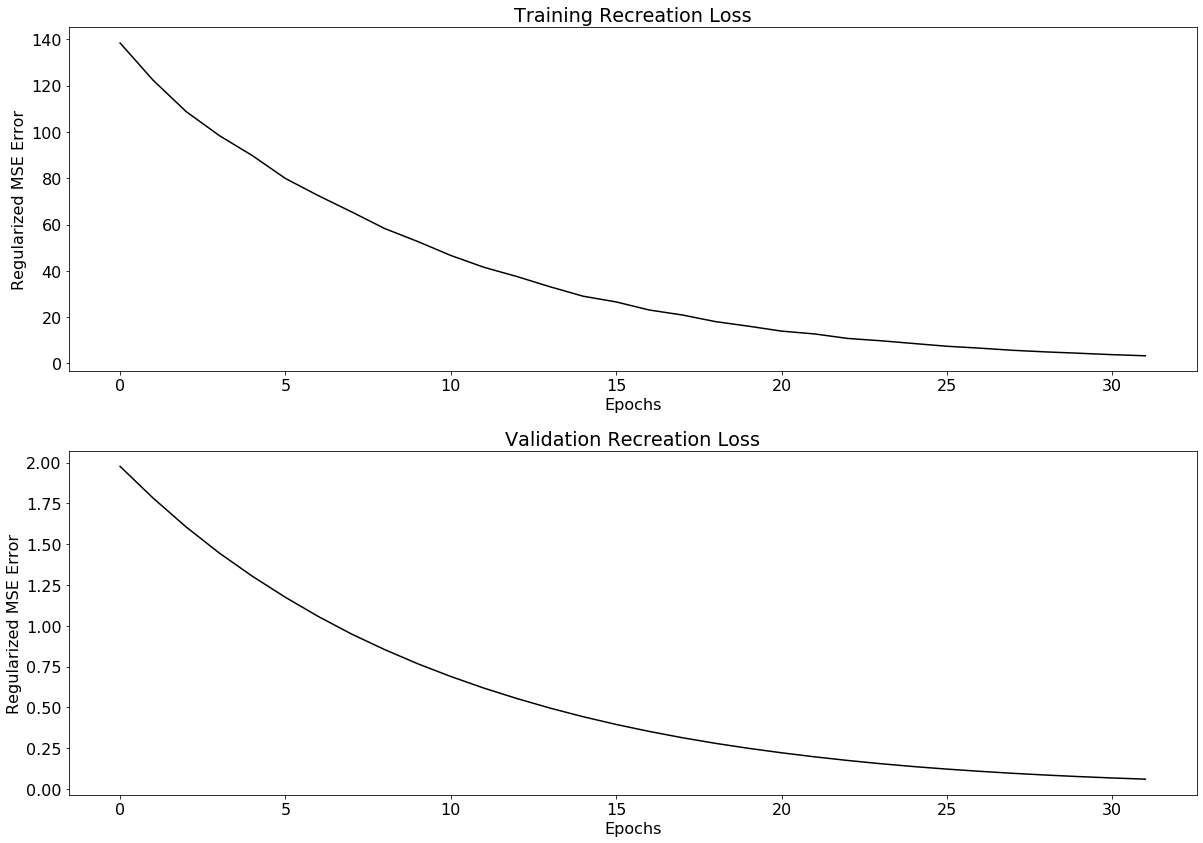

In [52]:
plt.rcParams['figure.figsize'] = 17, 12
plt.rcParams.update({'font.size': 16})

t_epochs = range(epochs)

plt.subplot(2, 1, 1)
plt.plot(t_epochs, train_recreation_loss_history, "k")
plt.xlabel("Epochs")
plt.ylabel("Regularized MSE Error")
plt.title("Training Recreation Loss")

plt.subplot(2, 1, 2)
plt.plot(t_epochs, validation_recreation_loss_history, "k")
plt.xlabel("Epochs")
plt.ylabel("Regularized MSE Error")
plt.title("Validation Recreation Loss")

plt.tight_layout()
plt.show()

<br>

___From the tensorboard___

__Training Recreation Loss Curve for `32` epochs (`14112` iterations)__

<img src = "./tensorboard_plots/ERROR_SUMMARIES_train_recreation_error.svg">

__Validation Recreation Loss Curve for `32` epochs (`14112` iterations)__

<img src = "./tensorboard_plots/ERROR_SUMMARIES_val_recreation_error.svg">

<br>

## 6 Testing the AutoEncoder

### 6.1 Testing using `test_input` and `test_output`

#### 6.1.1 Test Dataset Recreation Error

In [53]:
with tf.Session(graph = G) as session:
    
    # let's load our saved session data
    save_graph_state.restore(session, model_dump_path)
    clear_output()
            
    # you will need to start the iterator so that they are ready to
    # flow-transfer data into the graph
    # ("Open the taps for the test dataset")
    session.run(test_tap.initializer)
    
    # get the test recreation error
    error = session.run(test_recreation_error)
    
    # get the untouched MSE error
    raw_error = session.run(test_recreation_error_raw)

#### 6.1.2 Test Dataset MSE Error Distribution

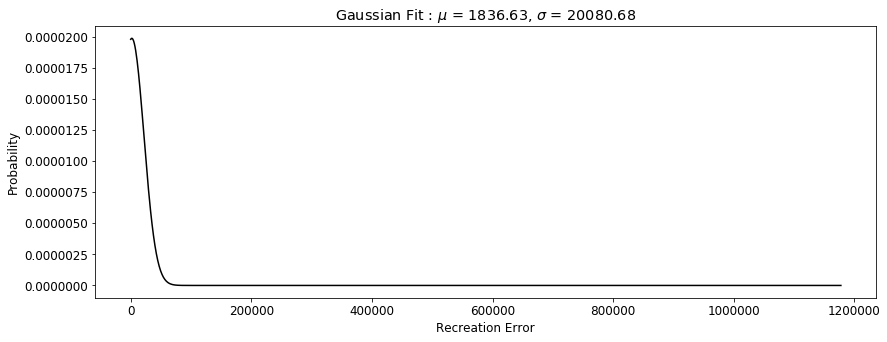

In [54]:
from scipy.stats import norm

# Fit a normal distribution to the data
mean, std = norm.fit(raw_error)

# Plot the PDF
plt.rcParams['figure.figsize'] = 14, 5
plt.rcParams.update({'font.size': 12})
xmin, xmax = np.min(raw_error), np.max(raw_error)
x = np.linspace(xmin, xmax, 1000)
pdf = norm.pdf(x, mean, std)
plt.plot(x, pdf, "k", linewidth = 1.5)

title = "Gaussian Fit : $\mu$ = %0.02f, $\sigma$ = %0.02f" % (mean, std)
plt.title(title)
plt.xlabel("Recreation Error")
plt.ylabel("Probability")

plt.show()

<br>

### 6.2 Obtaining MSE Error Distributions for fraudulent and non-fraudulent transactions

#### 6.2.1 Define _tf ops_ for MSE Error Distribution for fraudulent transactions using `G`

In [55]:
with G.as_default():
    
    with tf.name_scope("CUSTOM_DATA_TESTING"):
        
        # this placeholder tensor can accept one or multiple transaction data with
        # the specified number of features
        FT_input = tf.placeholder(dtype = tf.float32,
                                 shape = [None, hyperparameters["number_of_features"]],
                                 name = "custom_test_dataset")
        
        # this constant placeholder should contain the number of rows in FT_input
        custom_test_batch_size = tf.constant(value = -1, 
                                             dtype = tf.float32,
                                             name = "custom_test_batch_size")
        
        # perform a forward pass
        FT_predicted_output = perform_one_forward_pass(input_data = FT_input,
                                                       layers = layers,
                                                       full_pass = True)
        
        # obtain the raw recreation error
        FT_recreation_error_raw = tf.keras.losses.MSE(y_true = FT_input,
                                                      y_pred = FT_predicted_output)

#### 6.2.2 Run a session and obtain the required raw recreation errors

In [56]:
with tf.Session(graph = G) as session:
    
    # let's load our saved session data
    save_graph_state.restore(session, model_dump_path)
    clear_output()
    
    # you will need to start the iterator so that they are ready to
    # flow-transfer data into the graph
    # ("Open the taps for the validation and test dataset")
    session.run(validation_tap.initializer)
    session.run(test_tap.initializer)
    
    # get the untouched MSE test error
    test_error_raw = session.run(test_recreation_error_raw)
    
    # get the untouched validation MSE error
    validation_error_raw = session.run(val_recreation_error_raw)
    
    # get the untouched custom dataset MSE error
    FT_error_raw = session.run(FT_recreation_error_raw, 
                               feed_dict = {FT_input:np.array(X_F, dtype = np.float32),
                                            custom_test_batch_size:X_F.shape[0]})

In [57]:
NFT_error_raw = np.append(validation_error_raw, test_error_raw, axis = 0)

#### 6.2.3 MSE Error Distribution for the two types of transactions

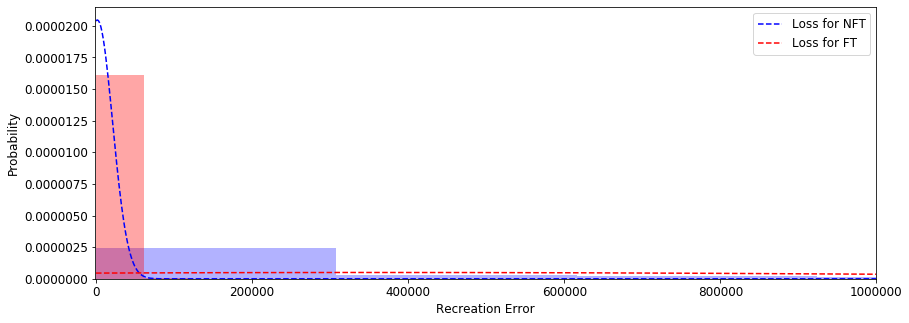

In [60]:
from scipy.stats import norm

# Fit a normal distribution to the data
FT_mean, FT_std = norm.fit(FT_error_raw)
NFT_mean, NFT_std = norm.fit(NFT_error_raw)

# plot the histogram.
plt.hist(FT_error_raw, bins = 25, density = True, alpha = 0.3, color = "b")
plt.hist(NFT_error_raw, bins = 25, density = True, alpha = 0.35, color = "r")

# Plot the PDF for non-fraudulent transactions
xmin, xmax = np.min(NFT_error_raw), np.max(NFT_error_raw)
x = np.linspace(xmin, xmax, 1000)
pdf = norm.pdf(x, NFT_mean, NFT_std)
plt.plot(x, pdf, "b--", linewidth = 1.5)

# Plot the PDF for fraudulent transactions
xmin, xmax = np.min(FT_error_raw), np.max(FT_error_raw)
x = np.linspace(xmin, xmax, 1000)
pdf = norm.pdf(x, FT_mean, FT_std)
plt.plot(x, pdf, "r--", linewidth = 1.5)

plt.xlabel("Recreation Error")
plt.ylabel("Probability")
plt.legend(["Loss for NFT", "Loss for FT"])
plt.xlim([-1e3, 1e6])

plt.show()

_You should see that the MSE error distributions for the non-fraudulent and fraudulent transactions have different probability distributions. This can help identity whether a new transaction has a high probability of being fraudulent or not (think hypothesis testing)_